In [2]:
import sys
import os

# Obtener la ruta al directorio padre
root = os.path.abspath(r'..\..')

# Agregar la ruta al sys.path para que Python busque en el directorio padre
sys.path.append(root)


import h5py as h5
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow import keras
from modules.loaders import LoadDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
###* Load the dataset
dataset = LoadDataset('positions_all_statics.h5').load_h5()
type(dataset)

h5py._hl.files.File

In [4]:
with dataset as h5file:
    data_h5 = []
    labels = []
    for letter in h5file.keys():
        positions = h5file[letter]['positions'][:]
        data_h5.append(positions)
        # print(positions.shape)
        labels.extend([letter]*positions.shape[1]) # extend is used to add the elements of the list, not the list itself  

labels = np.array(labels)
labels_letter = np.reshape(labels, (labels.shape[0], ))
labels_letter.shape


(4129,)

In [5]:
for i, id in enumerate(data_h5):
    print('Data shape',i, id.shape)

Data shape 0 (84, 192)
Data shape 1 (84, 200)
Data shape 2 (84, 200)
Data shape 3 (84, 200)
Data shape 4 (84, 200)
Data shape 5 (84, 200)
Data shape 6 (84, 200)
Data shape 7 (84, 200)
Data shape 8 (84, 200)
Data shape 9 (84, 198)
Data shape 10 (84, 200)
Data shape 11 (84, 193)
Data shape 12 (84, 202)
Data shape 13 (84, 203)
Data shape 14 (84, 200)
Data shape 15 (84, 203)
Data shape 16 (84, 202)
Data shape 17 (84, 204)
Data shape 18 (84, 208)
Data shape 19 (84, 161)
Data shape 20 (84, 163)


#### Remember nx -> 21*4 (positions in x and y)     m -> number of samples

In [6]:
label_encoder = LabelEncoder() ###* LETTERS TO NUMBERS 
labels = label_encoder.fit_transform(labels_letter)
print('The number of classes is:', len(label_encoder.classes_))
labels.shape

The number of classes is: 21


(4129,)

In [7]:
label_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O',
       'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y'], dtype='<U1')

### For every sample m we have one label

In [8]:
data = np.concatenate(data_h5,axis=1)
data.shape

(84, 4129)

#### sklearn needs data.shape = (m, nx), where:
#### m is the number of samples
#### nx number of featues (positions in this case)

In [9]:
data = data.T
data.shape


(4129, 84)

In [10]:
data[0,:]

array([383,  58, 349, 107, 410,  62, 333, 102, 434,  65, 301,  92, 456,
        69, 279,  86, 476,  72, 268,  82, 412,  62, 271,  83, 418,  63,
       251,  77, 418,  63, 277,  85, 414,  62, 283,  87, 393,  59, 273,
        84, 400,  60, 258,  79, 403,  61, 290,  89, 398,  60, 288,  88,
       374,  56, 278,  85, 380,  57, 267,  82, 385,  58, 294,  90, 381,
        57, 292,  90, 355,  53, 286,  88, 361,  54, 276,  85, 369,  55,
       293,  90, 367,  55, 295,  90], dtype=int64)

In [11]:
X_train, X, y_train, Y = train_test_split(data, labels, test_size=0.4)

In [12]:
X_train.shape, y_train.shape, X.shape, Y.shape

((2477, 84), (2477,), (1652, 84), (1652,))

#### Now we have our train dataset but we need a dev and test dataset

In [13]:
X_dev, X_test, y_dev, y_test = train_test_split(X, Y, test_size=0.5, )

In [14]:
m = X_train.shape[0] # number of samples
print(f'Traininig set: {X_train.shape[0]} samples')
print(f'Dev set: {X_dev.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Traininig set: 2477 samples
Dev set: 826 samples
Test set: 826 samples


##### We have 60% for training and 20% for dev,test data
##### Now we need to normalize the data, let's to use the z-score method

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #* Normalize X_train using the mean and standard deviation of the training set
X_dev = scaler.transform(X_dev)  #* Normalize X_test using the mean and standard deviation of the training set
X_test = scaler.transform(X_test)  #* Normalize X_test using the mean and standard deviation of the training set

### ONE HOT to create our matrix with labels

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_dev_onehot = encoder.transform(y_dev.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
y_train_onehot.shape, y_dev_onehot.shape, y_test_onehot.shape

((2477, 21), (826, 21), (826, 21))

In [17]:
# Convertir el array a una serie de pandas
import pandas as pd
y_dev_series = pd.Series(y_dev)

# Contar la frecuencia de cada elemento
element_counts = y_dev_series.value_counts()
print(element_counts)

1     49
5     48
15    47
3     46
6     46
8     42
2     41
18    41
10    41
14    40
11    39
7     39
0     38
12    37
9     37
4     36
16    36
20    36
17    34
13    29
19    24
Name: count, dtype: int64


#### Let's to build our first NEURAL NETWORK

Epoch 1/100


c:\Users\hgera\OneDrive\Escritorio\GITHUB\Computer-vision-LSM\env\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.1445 - loss: 3.3293 - val_categorical_accuracy: 0.4709 - val_loss: 2.1761
Epoch 2/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.5109 - loss: 1.9967 - val_categorical_accuracy: 0.6864 - val_loss: 1.4488
Epoch 3/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.6982 - loss: 1.4194 - val_categorical_accuracy: 0.7615 - val_loss: 1.1727
Epoch 4/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.7851 - loss: 1.1563 - val_categorical_accuracy: 0.8196 - val_loss: 1.0107
Epoch 5/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.8462 - loss: 1.0154 - val_categorical_accuracy: 0.8414 - val_loss: 0.9087
Epoch 6/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8573 - loss: 0.9051 - val_categorical_accuracy: 0.8729 - val_loss: 0.8358
Epoch 7/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.8737 - loss: 0.

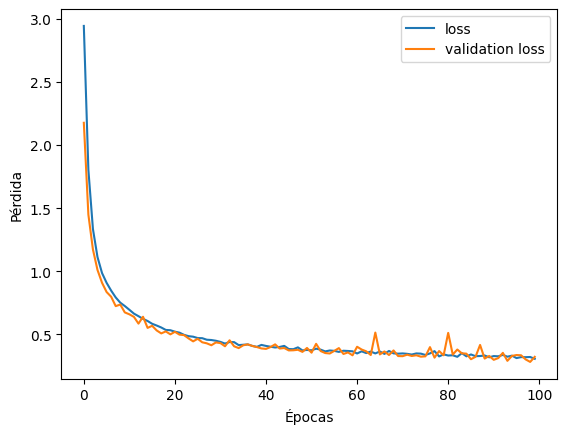

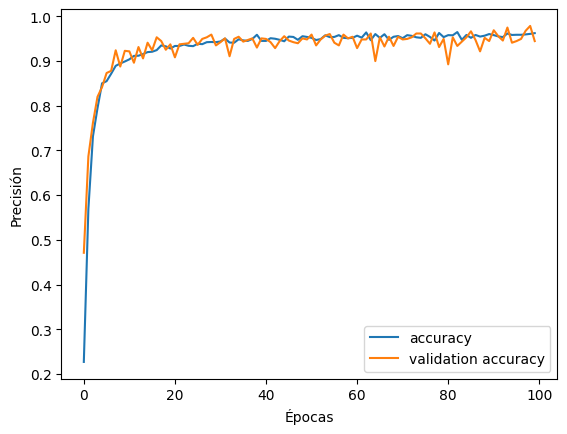

In [18]:
from tensorflow.keras.optimizers import Adam
num_classes = y_train_onehot.shape[1]  # Número de clases

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(84,)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Dropout con 50% de probabilidad
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Entrenar el modelo
history = model.fit(X_train, y_train_onehot,
                    epochs=100,
                    batch_size=4,
                    validation_data=(X_dev, y_dev_onehot),
                    callbacks=[early_stopping])

# Opcional: Graficar la pérdida y la precisión durante el entrenamiento
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


plt.plot(history.history['categorical_accuracy'], label='accuracy') 
plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [19]:
max(history.history['loss'])

2.943251609802246

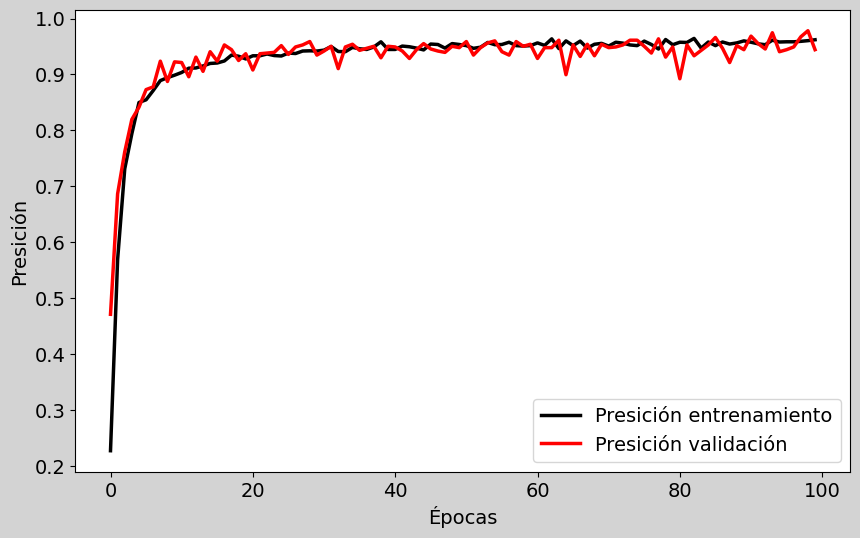

In [20]:

plt.rcParams.update({'font.size': 14})

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar la precisión
ax.plot(history.history['categorical_accuracy'], label='Presición entrenamiento', color='black', linewidth=2.5, linestyle='-') 
ax.plot(history.history['val_categorical_accuracy'], label='Presición validación', color='red', linewidth=2.5, linestyle='-')

# Configurar etiquetas y leyenda
ax.set_xlabel('Épocas')
ax.set_ylabel('Presición')
ax.legend()

# Agregar una cuadrícula
# ax.grid()

# Configurar el fondo del área de los ejes
ax.set_facecolor('white')

# Configurar el fondo del área fuera de los ejes
fig.patch.set_facecolor('lightgrey')
fig.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\accuracy_python.pdf')
# Mostrar la figura
plt.show()

# Guardar la figura (descomentando la línea si es necesario)


In [21]:
c_acuracy = history.history['categorical_accuracy'][0::5]
v_acuracy = history.history['val_categorical_accuracy'][0::5]
epocas = np.arange(1, len(history.history['categorical_accuracy']) + 1, 5)


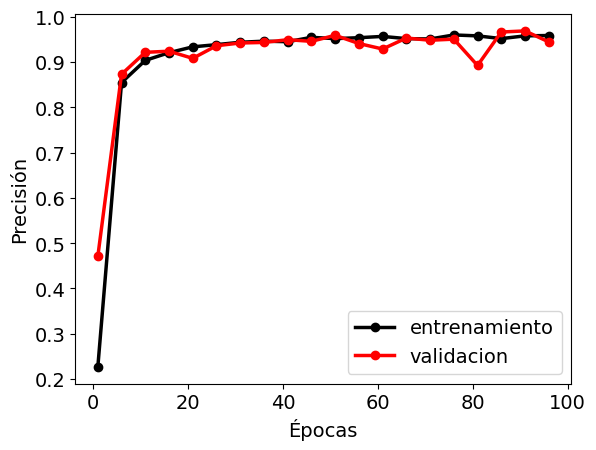

In [22]:
plt.plot(epocas,c_acuracy, label='entrenamiento', color='black', linewidth=2.5, linestyle='-', marker='o')
plt.plot(epocas,v_acuracy, label='validacion', color='red', linewidth=2.5, linestyle='-', marker='o')
plt.legend()

plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\accuracy_python.pdf')


In [23]:
# Evaluar el modelo
print('***'*50)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f'Acuraccy on training data: {test_acc:.2f}')
print(f'Loss on training data: {test_loss:.2f}')


******************************************************************************************************************************************************
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9753 - loss: 0.2945 
Acuraccy on training data: 0.97
Loss on training data: 0.30


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


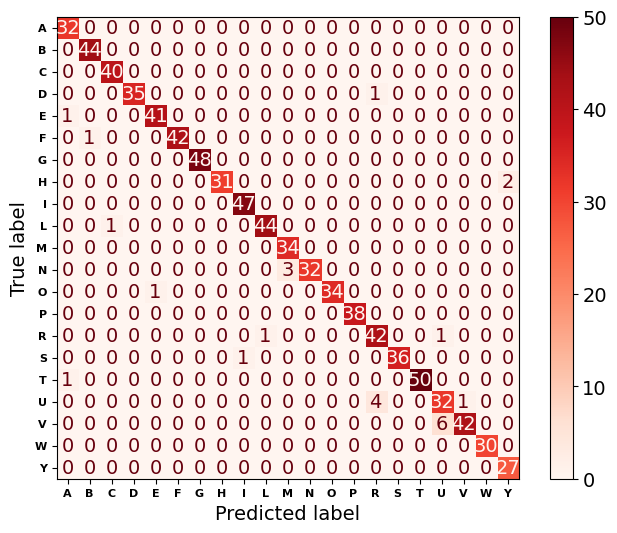

Categorical Accuracy: 0.9697
Accuracy per class: [1.         1.         1.         0.97222222 0.97619048 0.97674419
 1.         0.93939394 1.         0.97777778 1.         0.91428571
 0.97142857 1.         0.95454545 0.97297297 0.98039216 0.86486486
 0.875      1.         1.        ]


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predicciones del modelo
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Predicciones

# Verdaderos valores
y_true_class = np.argmax(y_test_onehot, axis=1)  # Valores reales

# Matriz de confusión
cm = confusion_matrix(y_true_class, y_pred)

# Crear el display de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot con ajustes
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Reds', xticks_rotation='vertical', ax=ax)
# Poner en negrita las etiquetas de los ejes X y Y
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=10)

# Cambiar el tamaño de la letra
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(8)  # Tamaño más pequeño para las etiquetas
plt.xticks(rotation=0)

# Ajustar la transparencia
for text in ax.texts:
    text.set_alpha(1)  # Ajustar la transparencia
plt.savefig(r'C:\Users\hgera\Downloads\confusion_matrix_statics.pdf')

plt.show()

# Sumar los valores diagonales (predicciones correctas)
correct_predictions = np.trace(cm)

# Sumar todos los valores de la matriz (total de predicciones)
total_predictions = np.sum(cm)

# Calcular la categorical accuracy
categorical_accuracy = correct_predictions / total_predictions

print(f'Categorical Accuracy: {categorical_accuracy:.4f}')
# Precisión por clase
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print("Accuracy per class:", accuracy_per_class)

In [25]:
ASAS

NameError: name 'ASAS' is not defined

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Clase 0: Best treshold = 0.11134198307991028
Clase 1: Best treshold = 0.5798009634017944
Clase 2: Best treshold = 0.6465752124786377
Clase 3: Best treshold = 0.006521308328956366
Clase 4: Best treshold = 0.47256457805633545
Clase 5: Best treshold = 0.2581957280635834
Clase 6: Best treshold = 0.27143359184265137
Clase 7: Best treshold = 0.24965740740299225
Clase 8: Best treshold = 0.7670965194702148
Clase 9: Best treshold = 0.14160697162151337
Clase 10: Best treshold = 0.10288183391094208
Clase 11: Best treshold = 0.03305191174149513
Clase 12: Best treshold = 0.5011406540870667
Clase 13: Best treshold = 0.4729726016521454
Clase 14: Best treshold = 0.4176914393901825
Clase 15: Best treshold = 0.4111994802951813
Clase 16: Best treshold = 0.4984729588031769
Clase 17: Best treshold = 0.22746460139751434
Clase 18: Best treshold = 0.6246843338012695
Clase 19: Best treshold = 0.7391343712806702
Clase 20: Best treshold = 0.7363201379776001


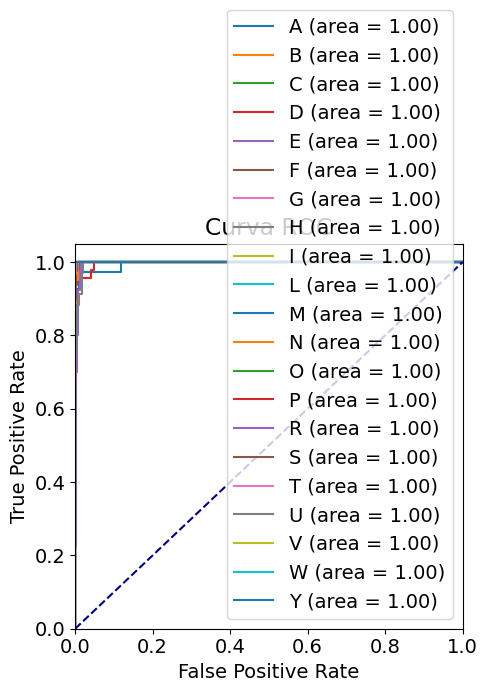

Optimized Tresholds per class  [0.11134198 0.57980096 0.64657521 0.00652131 0.47256458 0.25819573
 0.27143359 0.24965741 0.76709652 0.14160697 0.10288183 0.03305191
 0.50114065 0.4729726  0.41769144 0.41119948 0.49847296 0.2274646
 0.62468433 0.73913437 0.73632014]


In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
y_pred = model.predict(X_test)
num_classes = y_train_onehot.shape[1]
best_thresholds = np.zeros(num_classes)

plt.figure(figsize=(5, 5))

#### Calculate ROC curve and ROC area for each class
for i in range(num_classes):
    y_true_binary = (y_true_class == i).astype(int)
    # print(y_true_binary)
    #### Compute ROC curve and ROC area
    fpr, tpr, threshold = roc_curve(y_true_binary, y_pred[:,i])
    #### Calcualte Youden's J statistic
    J = tpr - fpr
    best_threshold = threshold[np.argmax(J)]
    best_thresholds[i] = best_threshold
    
    print(f'Clase {i}: Best treshold = {best_threshold}')
    
    
    
    ## Calcular el área bajo la curva ROC
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (area = {round(roc_auc,3)})')
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()



print('Optimized Tresholds per class ',best_thresholds)

In [40]:
asasas

NameError: name 'asasas' is not defined

In [ ]:
#* Save the model
path_save = '..\\..\\models\\Trained\\signs\\all_statics_model.h5'
model.save(path_save)

In [22]:
model = tf.keras.models.load_model(path_save)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599 (10.16 KB)

 Trainable params: 2,597 (10.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [23]:
# Supongamos que tienes datos nuevos para predecir
dict_labels = {i: letter for i, letter in enumerate(label_encoder.classes_)}
new_data = data_h5[2][:, 119 ]  # Supongamos que solo tenemos un dato nuevo
new_data = new_data.reshape(1, -1)  # Convertirlo a un arreglo 2D
print(new_data.shape)
# Preprocesar los datos nuevos (normalización, etc.)
new_data_normalized = scaler.transform(new_data)  # Normalización Z-score

# Hacer predicciones
predictions = model.predict(new_data_normalized)

# Convertir las predicciones a etiquetas
predicted_class = np.argmax(predictions, axis=1)

print(f'Predicción: {dict_labels[predicted_class[0]]}')

(1, 84)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicción: C


#### SAVE the values of the normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

joblib.dump(scaler, '..\\..\\models\\Trained\\signs\\all_statics_scaler.pkl')


Escalador ajustado y guardado en 'scaler.pkl'


(-0.5, 699.5, 499.5, -0.5)

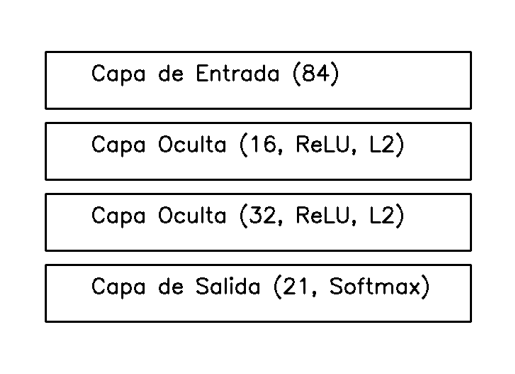

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parámetros para la red neuronal
input_shape = 84  # Número de neuronas de entrada
num_classes = 21  # Número de neuronas de salida (clases)
hidden_layers = [(16, 'ReLU', 'L2'), (32, 'ReLU', 'L2')]  # Capas ocultas con número de neuronas, activación y regularización

# Crear una imagen en blanco
height, width = 500, 700  # Dimensiones de la imagen
image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Fondo blanco

# Coordenadas iniciales y finales para dibujar las capas
start_x = 50
end_x = width - 50
layer_height = 100  # Altura de cada capa

# Dibujar la capa de entrada
cv2.putText(image, f'    Capa de Entrada ({input_shape})', (start_x, layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, layer_height - 40), (end_x, layer_height + 40), (0, 0, 0), 2)

# Dibujar capas ocultas
for i, (neurons, activation, regularization) in enumerate(hidden_layers, start=2):
    cv2.putText(image, f'    Capa Oculta ({neurons}, {activation}, {regularization})', 
                (start_x, i * layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.rectangle(image, (start_x, i * layer_height - 40), (end_x, i * layer_height + 40), (0, 0, 0), 2)

# Dibujar la capa de salida
cv2.putText(image, f'    Capa de Salida ({num_classes}, Softmax)', (start_x, (len(hidden_layers) + 2) * layer_height), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, (len(hidden_layers) + 2) * layer_height - 40), 
              (end_x, (len(hidden_layers) + 2) * layer_height + 40), (0, 0, 0), 2)

# Mostrar la imagen
# cv2.imshow('Red Neuronal', image)
plt.imshow(image)
plt.axis('off')

